# Charged Particle Motion: Dipole-VS
Boris particle tracing code for computing charged particle motion in Earth's Magnetopshere with dipole magnetic field and volland-stern electric field.

## Preamble

In [1]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import Axes3D
import time
import warnings
from bfields import *
from efields import *

# Use %matplotlib notebook to change to a zoom-able display.
%matplotlib inline

## Useful Functions

### Draw a 3D Earth

In [2]:
def earth3D(rad):
    '''
    rad is in earth radii [RE]
    
    '''
    ns     = 100 # numbner samples
    stride = 1

    # phi; goes from [0:2*PI]
    phi = np.linspace(0.,2.*np.pi,ns)

    # theta; goes from [0:PI]
    tht = np.linspace(0.,np.pi,ns)

    x = rad*np.outer(np.cos(phi), np.sin(tht))
    y = rad*np.outer(np.sin(phi), np.sin(tht))
    z = rad*np.outer(np.ones(np.size(phi)), np.cos(tht))

    ax.plot_surface(x, y, z, linewidth=0.0, cstride=stride, rstride=stride, color = 'b')    

### Magnitude of a Vector

In [3]:
def mag(vec):

    magnitude = np.sqrt(np.dot(vec, vec))
    return magnitude

## Electric Field 

Earth's dipole field in terms of magnetic dipole moment $|\vec{m}|=7.79 \times 10^{22} \mathrm{Am}^{2}$, 

$$\vec{B}=\frac{\mu_{0}}{4 \pi r^{3}}[3(\vec{m} \cdot \hat{r}) \hat{r}-\vec{m}] \tag{Garcia-Farieta 2019; 1}|$$

### Volland Stern Electric Field Model - EDIT

Volland (1973) and Stern (1975) define the electric field model of the magnetosphere as a combination of a convection potential $\phi_{c}$ and corotation potential $\phi_{cr}$:
$$\mathrm{E}=-\nabla\left(\phi_{c}+\phi_{cr}\right) \tag{Stern (1975); 4}$$
Such that the total electric field can be defined as 
$$ E = E_{c}+E_{cr} $$
### Convection field $E_c$

Volland-Stern Convection field, where the potential can be written as

$$\phi_{c}=-A_{0} r^{\gamma} \sin \psi \tag{Ferradas (2017); 1.16}$$

Where the magnetic local time ($\psi$) is related to azimuth by $\psi = \phi/24$, and the  uniform convection electric field strength in the equatorial plane $A_0$ is

$$A_{0}=\frac{0.045}{\left(1-0.159 K p+0.0093 K p^{2}\right)^{3}} \frac{k V}{R_{E}^{2}}

\tag{Ferradas (2017); 2.4}$$

By solving the gradient $E_c = -\nabla \phi_c$, we find our equation for the convection potential:

$$E_{r} = A_0 \left (\gamma r^{\gamma-1}\sin (\phi/24) \hat{\mathbf{r}} +  0\hat{\boldsymbol{\theta}} + \frac{r^{\gamma-1}}{24\sin\theta}\cos (\phi/24) \hat{\boldsymbol{\phi}} \right )$$

### Corotation field $E_{cr}$
Cororation potential due to Earth's rotation defined by
$$\begin{equation}
\phi_{c r}=-\frac{\omega_E B_E R_E^3}{r}
\end{equation}$$
Solving the gradient as with the convection field defines a corotation electric field
$$\begin{equation}
E_{c r}=\frac{\omega_E B_E R_E^3}{r^2}
\end{equation}$$

## Simulation

### Setup

In [35]:
'''
Constants
'''
kp = 1.0        # kp index
gs = 2.0        # shielding constant
RE = 6371000    # radius of earth [m] 
mp = 1.6e-27    # proton mass [kg]
me = 9.1e-31    # electron mass [kg]
qe = 1.603E-19  # proton charge [C]

dt = 1e-4           # time step [s]
tf = 100 # 1950     # final time [s]
steps = int(tf/dt)  # number of iterations
print('dt = {0:1.1e}, T = {1:4.0f}, N = {2:d}'.format(dt, tf, steps))

# Allocate memory to results
tdat = np.zeros(steps)          # time [s]
rdat = np.zeros((steps,3))        # position [m]
vdat = np.zeros((steps,3))        # velocity [km/s]
tdat[-1] = tf

# creating charged particle
m = 4.*mp            # Mass of simulated test particle [kg]
q = 2.*qe            # Charge of simulated test particle [C]

# set initial conditions
#   - For reference, a 500 eV electron travels with a velocity of
#   - import numpy as np
#   - from scipy import constants as c
#   - v = np.sqrt(2 * 500 / c.physical_constants['joule-electron volt relationship'][0] / c.m_e)
#   - v = 13,262,051 m/s
RE = 6371000                                # radius of earth [m] 
rdat[0] = np.array([1., -3.85, -1.53])*RE   # [m]
vdat[0] = np.array([1e4,1e4,1e3]) * 1e3     # [m/s]

'''
# example
rdat[0] = np.array([1., -7.85, -1.53])*RE   # [m]
vdat[0] = np.array([0.,.3,.3])              # [m/s]
'''

# ELECTRIC FIELD TESTING
emag = np.zeros(steps)
edat = np.zeros((steps,3))
bdat = np.zeros((steps,3))

dt = 1.0e-04, T =  100, N = 1000000


### Boris Particle Tracing

In [49]:
# boris particle tracing
for i in tqdm(range(0, steps-1)):
    
    r = rdat[i]
    v = vdat[i]

    tdat[i] = i*dt

    # compute B-field [T]
    B0 = B_dipole(r)
    # B0 = np.array([0.,0.,0.])

    # compute convection E-field [mV/m]
    EC = vs_efield(r, gs, kp)

    # compute corotation E-field [mV/m]
    ER = corotation_efield(r)

    # compute total E-field and covert to [V/m]
    E0 = np.add(EC,ER)*1e-3
    E0 = np.array([0, 1, 0])*1e-3

    # take B,E values for testing
    bdat[i] = B0
    edat[i] = E0/1e-3
    emag[i] = mag(E0/1e-3)

    c0 = (dt*q*B0)/(2*m)

    # push step 1 - update velocity with half electrostatic contribution 
    v1 = v + (q*E0*dt)/(2*m)

    # push step 2 - rotated via the magnetic field contribution 
    ax = v1 + np.cross(v1,c0)
    bx = (2*c0)/(1+c0**2)
    v2 = v1 + np.cross(ax,bx)

    # push step 3 - updated again with another half of the electrostatic push [m/s]
    vnew = v2 + (q*E0*dt)/(2*m)

    # update position [m]
    rnew = r + vnew*dt

    # append to data arrays
    vdat[i+1] = vnew
    rdat[i+1] = rnew

  0%|          | 204/999999 [00:00<08:14, 2020.38it/s]

100%|██████████| 999999/999999 [05:07<00:00, 3247.78it/s]


### Plot Results

* Initial position: (1.0, -3.85, -1.53) RE
* Initial velocity: (10000000.0, 10000000.0, 1000000.0) m/s
* Duration: 100 s (1.67 min.)
* E-field: 1.00e+00 mV/m (mean), 1.00e+00 mV/m (max), 0.00e+00 mV/m (min) 


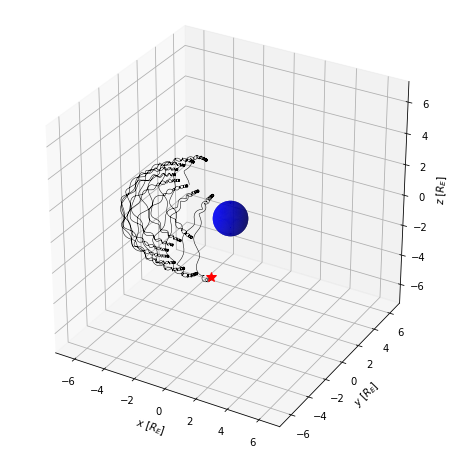

In [50]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

# radius of earth [m]
RE = 6371000  

# convert coordinates in units [RE]  
rscale = rdat/RE

# plot dipole field data
ax.plot3D(rscale[:,0],rscale[:,1],rscale[:,2],'k',linewidth=0.5)

# plot starting point
ax.plot(rscale[0][0],rscale[0][1],rscale[0][2],'r',marker='*', markersize=10)

# plot 3D earth
earth3D(1)

# graph correction, keeps origin (0,0,0) at center
ranges = []
ranges.append(math.ceil(max(abs(rscale[:,0]))))
ranges.append(math.ceil(min(abs(rscale[:,0]))))
ranges.append(math.ceil(max(abs(rscale[:,1]))))
ranges.append(math.ceil(min(abs(rscale[:,1]))))
ranges.append(math.ceil(max(abs(rscale[:,2]))))
ranges.append(math.ceil(min(abs(rscale[:,2]))))

axrng = max(ranges)

ax.set_xlim([-axrng, axrng])
ax.set_ylim([-axrng, axrng])
ax.set_zlim([-axrng, axrng])

# plot attributes
ax.set_box_aspect([1,1,1])
ax.set_xlabel('$x$ [$R_E$]')
ax.set_ylabel('$y$ [$R_E$]')
ax.set_zlabel('$z$ [$R_E$]')

# save figure
# fname = 'plot_ptrace_start'
# plt.savefig('../bin/'+fname+'.png',bbox_inches='tight', dpi=150)

# diagnostic data
print(f'* Initial position: {rscale[0][0], rscale[0][1], rscale[0][2]} RE')
print(f'* Initial velocity: {vdat[0][0], vdat[0][1], vdat[0][2]} m/s')
print(f'* Duration: {tf} s ({round(tf/60,2)} min.)')
print(f'* E-field: {np.mean(emag):.2e} mV/m (mean), {max(emag):.2e} mV/m (max), {min(emag):.2e} mV/m (min) ')

plt.show()


In [34]:
edat

array([[-9.47851099e-05,  0.00000000e+00,  1.31889558e-05],
       [-9.47851099e-05,  0.00000000e+00,  1.31889558e-05],
       [-9.47851099e-05,  0.00000000e+00,  1.31889558e-05],
       ...,
       [ 1.02596644e-04,  0.00000000e+00, -4.32136117e-05],
       [ 1.02593258e-04,  0.00000000e+00, -4.32134022e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

### Profile Plots

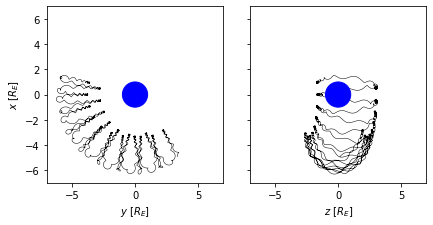

In [29]:
from matplotlib.patches import Circle

fig, ax = plt.subplots(1,2, sharey=True)
fig.tight_layout() 

ax[0].plot(rscale[:,1],rscale[:,0], 'k',linewidth=0.5)
ax[0].set_xlabel("$y$ [$R_E$]")
ax[0].set_ylabel("$x$ [$R_E$]")
ax[0].add_patch(Circle((0,0), 1., color='b', zorder = 10))

# fix axis
ax[0].set_xlim([-axrng, axrng])
ax[0].set_ylim([-axrng, axrng])
ax[0].set_aspect('equal')

ax[1].plot(rscale[:,2],rscale[:,0], 'k',linewidth=0.5)
ax[1].set_xlabel("$z$ [$R_E$]")
ax[1].set_ylabel("")
ax[1].add_patch(Circle((0,0), 1., color='b', zorder = 10))

# fix axis
ax[1].set_xlim([-axrng, axrng])
ax[1].set_ylim([-axrng, axrng])
ax[1].set_aspect('equal')

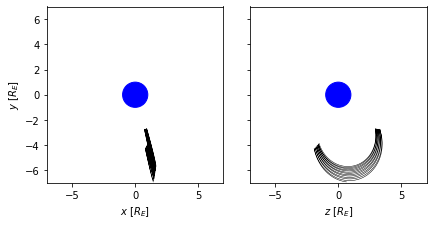

In [21]:
fig, ax = plt.subplots(1,2, sharey=True)
fig.tight_layout() 

ax[0].plot(rscale[:,0],rscale[:,1], 'k',linewidth=0.5)
ax[0].set_xlabel("$x$ [$R_E$]")
ax[0].set_ylabel("$y$ [$R_E$]")
ax[0].add_patch(Circle((0,0), 1., color='b', zorder = 10))

# fix axis
ax[0].set_xlim([-axrng, axrng])
ax[0].set_ylim([-axrng, axrng])
ax[0].set_aspect('equal')

ax[1].plot(rscale[:,2],rscale[:,1], 'k',linewidth=0.5)
ax[1].set_xlabel("$z$ [$R_E$]")
ax[1].set_ylabel("")
ax[1].add_patch(Circle((0,0), 1., color='b', zorder = 10))

# fix axis
ax[1].set_xlim([-axrng, axrng])
ax[1].set_ylim([-axrng, axrng])
ax[1].set_aspect('equal')

# Plot Time Series

/Users/argall/anaconda3/envs/imef/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/Users/argall/anaconda3/envs/imef/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, '$\\mu$')

/Users/argall/anaconda3/envs/imef/lib/python3.6/site-packages/IPython/core/events.py:74: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/argall/anaconda3/envs/imef/lib/python3.6/site-packages/IPython/core/pylabtools.py:131: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


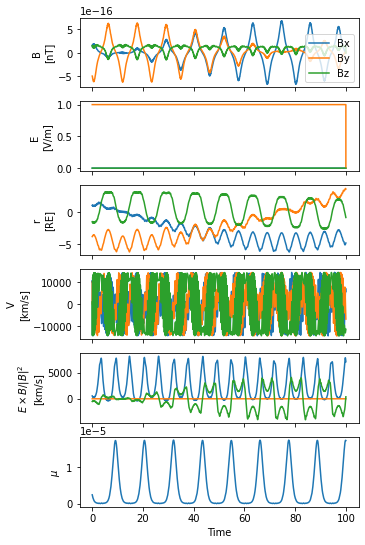

In [51]:
fig, axes = plt.subplots(nrows=6, ncols=1, squeeze=False, figsize=(5,9))

# Magnetic Field
ax = axes[0,0]
ax.plot(tdat, bdat[:,0]/1e9, label='Bx')
ax.plot(tdat, bdat[:,1]/1e9, label='By')
ax.plot(tdat, bdat[:,2]/1e9, label='Bz')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('B\n[nT]')
ax.legend()

# Electric Field
ax = axes[1,0]
ax.plot(tdat, edat[:,0])
ax.plot(tdat, edat[:,1])
ax.plot(tdat, edat[:,2])
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('E \n[V/m]')

# Position
ax = axes[2,0]
ax.plot(tdat, rdat[:,0]/RE)
ax.plot(tdat, rdat[:,1]/RE)
ax.plot(tdat, rdat[:,2]/RE)
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('r\n[RE]')

# Velocity
ax = axes[3,0]
ax.plot(tdat, vdat[:,0]*1e-3)
ax.plot(tdat, vdat[:,1]*1e-3)
ax.plot(tdat, vdat[:,2]*1e-3)
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('V\n[km/s]')

# ExB drift velocity
exb_drift = 1e-3 * np.cross(edat, bdat) / np.linalg.norm(bdat, ord=2, axis=1)[:,np.newaxis]**2
ax = axes[4,0]
ax.plot(tdat, exb_drift[:,0])
ax.plot(tdat, exb_drift[:,1])
ax.plot(tdat, exb_drift[:,2])
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('$E \\times B/|B|^{2}$\n[km/s]')

# 1st adiabatic invariant
b_mag = np.linalg.norm(bdat, ord=2, axis=1)
b_hat = bdat / b_mag[:, np.newaxis]
v_perp = np.linalg.norm(vdat, ord=2, axis=1) - np.sum(vdat * b_hat, axis=1)
mu = 0.5 * m * v_perp**2 / b_mag
ax = axes[5,0]
ax.plot(tdat, mu)
ax.set_xlabel('Time')
ax.set_ylabel('$\mu$')

### Refrences
* Volland, H. 1973. “A semiempirical model of large-scale magnetospheric electric fields.”Journal of Geophysical
Research.https://doi.org/10.1029/JA078i001p00171.
* Stern, D. 1975. The motion of a proton in the equatorial magnetosphere. Journal of Geophysical
Research.https://doi.org/10.1029/JA080i004p00595.
* J. E. García-Farieta and A. Hurtado, “Simulation of charged particles in Earth’s magnetosphere: an approach to the Van Allen belts”, Rev. Mex. Fis. E, vol. 65, no. 1 Jan-Jun, pp. 64–70, Jan. 2019.
* Ferradas, C. (2017). <i>Understanding Ion Spectral Dynamics Near the Inner Edge Of The Plasma Sheet. https://scholars.unh.edu/dissertation
* https://en.wikipedia.org/wiki/Magnetic_dipole
* http://physicsinsights.org/dipole_field_1.html


### WIP Below

In [168]:
def vdrift(E, B):
    
    B0 = mag(B)
    ans = np.cross(E,B)/B0**2
    return ans

ddat = []

for i in range(0,steps-1):
    
    exb = vdrift(edat[i],bdat[i])
    
    ddat.append(mag(exb))    
    
ddat

[4.753989582782215,
 4.753896475640795,
 4.753785315927461,
 4.753656057219165,
 4.753508653333515,
 4.753343058330751,
 4.753159226515765,
 4.752957112440063,
 4.752736670903775,
 4.752497856957658,
 4.752240625905041,
 4.751964933303897,
 4.751670734968768,
 4.7513579869727645,
 4.751026645649613,
 4.750676667595585,
 4.7503080096715555,
 4.749920629004933,
 4.749514482991748,
 4.749089529298569,
 4.748645725864571,
 4.748183030903523,
 4.747701402905767,
 4.747200800640297,
 4.746681183156721,
 4.7461425097873065,
 4.7455847401490034,
 4.745007834145469,
 4.744411751969081,
 4.743796454103028,
 4.743161901323279,
 4.7425080547006955,
 4.741834875603031,
 4.741142325697015,
 4.740430366950417,
 4.7396989616340734,
 4.738948072324023,
 4.7381776619035225,
 4.7373876935651795,
 4.736578130812993,
 4.735748937464507,
 4.734900077652849,
 4.734031515828907,
 4.7331432167633825,
 4.7322351455489615,
 4.731307267602408,
 4.730359548666735,
 4.729391954813318,
 4.728404452444062,
 4.7273970

In [16]:
# plot E-field
# eplot = ax1.pcolormesh(phi, rscale, emap_new, cmap=pcolor, shading='nearest')
# fig.colorbar(eplot, ax=ax1, pad=0.13, label="$E_c$ [mV/m]")

emag = []

for i in edat:
    emag.append(mag(i))
    
print(emag)    
'''
fig, ax = plt.subplots(1,2, sharey=True)
fig.tight_layout() 

ax[0].pcolormesh(rscale[:,1],rscale[:,0], emag, linewidth=0.5, shading='nearest')
ax[0].set_xlabel("$y$ [$R_E$]")
ax[0].set_ylabel("$x$ [$R_E$]")
ax[0].add_patch(Circle((0,0), 1., color='b', zorder = 10))
'''

In [10]:
# generate meshgrid

def vs_potential(coords, gs, kp, sph = False):
    
    if sph == False:
        # convert cartesian to spherical coordinates
        rgeo, theta, phi = crt_to_sph(coords[0], coords[1], coords[2])

    else:
        # unpack coordinates
        rgeo  = coords[0]
        theta = coords[1]
        phi   = coords[2]

    # uniform convection electric field strength in equatorial plane [kV]
    E0 = convection_field(kp)

    # VS potential
    U = -E0*(rgeo**gs)*math.sin(phi)
    
    return U

dr = 300  # incrementation
drx = np.linspace(min(rdat[0]), max(rdat[0]), dr)
dry = np.linspace(min(rdat[1]), max(rdat[1]), dr)
drz = np.linspace(min(rdat[2]), max(rdat[2]), dr)

rx, ry, rz = np.meshgrid(drx, dry, drz)


# coordinates

# array 
umap_new = np.zeros(rx.shape) # Potential

# calculate potential and assign values to array
for i in range(0,dr):
    for j in range(0,dr):
        for k in range(0,dr):

        
            r0 = rx[i,j,k]
            r1 = ry[i,j,k]
            r2 = rz[i,j,k]
            coords = np.array([r0, r1, r2])

            umap_new[i,j,k] = vs_potential(coords, gs, kp, sph = False)
            




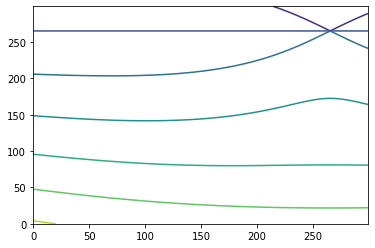

In [11]:
s =umap_new[:,:,60]
s.shape
cs = plt.contour(s, 8)


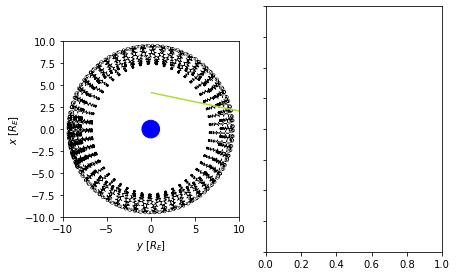

In [12]:
fig, ax = plt.subplots(1,2, sharey=True)
fig.tight_layout() 

ax[0].plot(rdat[:,1],rdat[:,0], 'k',linewidth=0.5)
ax[0].set_xlabel("$y$ [$R_E$]")
ax[0].set_ylabel("$x$ [$R_E$]")
ax[0].add_patch(Circle((0,0), 1., color='b', zorder = 10))

# fix axis
ax[0].set_xlim([-axrng, axrng])
ax[0].set_ylim([-axrng, axrng])
ax[0].set_aspect('equal')

ax[0].contour(s, 8)

In [13]:
'''# WIP, IGNORE BELOW'''

def boris(dt, tf, m, q, r0, v0):
    steps = int(tf/dt)

    rdat = np.zeros((steps,3))
    vdat =  np.zeros((steps,3))
    edat = np.zeros((steps,3))
    tdat = np.zeros(steps)

    rdat[0] = r0
    vdat[0] = v0

    for i in range(0, steps-1):
    
        r = rdat[i]
        v = vdat[i]
        
        tdat[i] = i*dt

        # compute B-field
        B0 = B(r)

        # compute E-field
        r_geo = np.sqrt(np.dot(r,r))
        theta = np.arccos(r[2]/r_geo)
        phi = np.arctan2(r[0],r[1])
        
        E = vs_convection_efield(r_geo, theta, phi, kp, gs)

        # take E value for testing
        edat[i] = E
        
        c0 = (dt*q*B0)/(2*m)
        
        # push step 1 - update velocity with half electrostatic contribution
        v1 = v + (q*E*dt)/(2*m)
        
        # push step 2 - rotated via the magnetic field contribution 
        ax = v1 + np.cross(v1,c0)
        bx = (2*c0)/(1+c0**2)
        v2 = v1 + np.cross(ax,bx)
        
        # push step 3 - updated again with another half of the electrostatic push
        vnew = v2 + (q*E*dt)/(2*m)
        
        # update position
        rnew = r + vnew*dt
        
        # append to data arrays
        vdat[i+1] = vnew
        rdat[i+1] = rnew
    
    return rdat, vdat





In [14]:
dt = 0.001
tf = 20

# set initial conditions
r0 = np.array([1., -4.85, -1.53])
v0 = np.array([0.,.12,.2])

'''
# example
r0 = np.array([1., -7.85, -1.53])
v0 = np.array([0.,.3,.3])
'''
# creating charged particle
m = 4.*mp
q = 2.*qe

rdat, vdat = boris(dt, tf, m, q, r0, v0)

NameError: name 'vs_convection_efield' is not defined

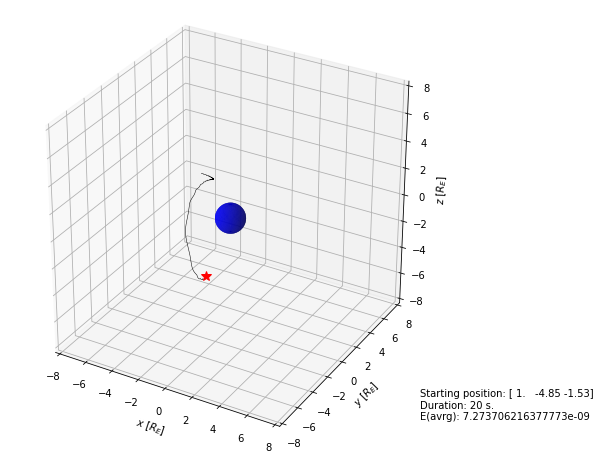

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

# plot dipole field data
ax.plot3D(rdat[:,0],rdat[:,1],rdat[:,2],'k',linewidth=0.5)

# plot starting point
ax.plot(rdat[0][0],rdat[0][1],rdat[0][2],'r',marker='*', markersize=10)

# plot 3D earth
earth3D(1)

# graph correction, keeps origin (0,0,0) at center
ranges = []
ranges.append(math.ceil(max(abs(rdat[:,0]))))
ranges.append(math.ceil(min(abs(rdat[:,0]))))
ranges.append(math.ceil(max(abs(rdat[:,1]))))
ranges.append(math.ceil(min(abs(rdat[:,1]))))
ranges.append(math.ceil(max(abs(rdat[:,2]))))
ranges.append(math.ceil(min(abs(rdat[:,2]))))

axrng = max(ranges)

ax.set_xlim([-axrng, axrng])
ax.set_ylim([-axrng, axrng])
ax.set_zlim([-axrng, axrng])

# plot attributes
ax.set_box_aspect([1,1,1])
ax.set_xlabel("$x$ [$R_E$]")
ax.set_ylabel("$y$ [$R_E$]")
ax.set_zlabel("$z$ [$R_E$]")

# average efield
eavrg = np.mean(edat)

# helpful text
ax.text2D(0.95, 0.05, f"Starting position: {rdat[0]} \nDuration: {tf} s. \nE(avrg): {eavrg}", 
transform=ax.transAxes)

plt.show()

In [ ]:
def func1(x,y,z):
    ans = x+y+z
    return ans

def func2(x,y,z):
    ans = x*y*z
    return ans


class model:
    def __init__(self, name, func):
        self.name = name # name of field model
        self.func = func # function used to compute the field at [x,y,z] coordinates

M1 = model("Model 1", func1)
M2 = model("Model 2", func2)

# how I would use it,

B1.func()


